# TODO:
* [x] replace next two rows with sorted image names
* [x] quality control - check for missing images in both variables
* [ ] balance train_df with sklearn
* [ ] balance batches (n, n) {0, 1} with Pytorch Samplers
* [x] crop train and test images to 32 x 32 (from center)
* [x] multiply loss.item() by batch_size (because default reduction value in Loss function is mean)
* [x] replace next two rows with sorted image names
* [x] quality control - check for missing images in both variables 
* [x] make bigger batch size for validation

# Hello there!
This is my almost first try to create a notebook. The main reason for this is because I have never seen the guides, where is NN building was described

# Imports

In [1]:
import gc
import os
from collections import Counter

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
from tqdm.notebook import tqdm


Don't forget to uncomment the `DATA_DIR` constant for Kaggle or use your path instead.

In [3]:
#Constants region
# DATA_DIR = "../input/histopathologic-cancer-detection/"
DATA_DIR = "../"
TRAIN_LABELS = 'train_labels.csv'

CENTER_SIZE = 64
BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 512
#End constant region

# Data Preparation

## Import dataset

In [4]:
train_df: pd.DataFrame = pd.read_csv(DATA_DIR + TRAIN_LABELS)
print(train_df.info())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## Check for duplicated values

In [5]:
print(train_df[train_df['id'].duplicated(keep=False)])

Empty DataFrame
Columns: [id, label]
Index: []


No duplicated values found.

## Check if dataset is balanced

In [6]:
Counter(train_df['label'])

Counter({0: 130908, 1: 89117})

As we can see, it is not balanced. Let's fix it. I choose to UNDERsample the dataset because I don't know how to synthesise new values for images.

In [7]:
normal = train_df.loc[train_df['label'] == 0]
malignant = train_df.loc[train_df['label'] == 1]

print(set(Counter(normal['id']).values()))
print(set(Counter(malignant['id']).values()))

{1}
{1}


In [8]:
balance_size = len(malignant)

In [9]:
normal = normal.to_numpy()
malignant = malignant.to_numpy()
print(normal.shape, malignant.shape)

(130908, 2) (89117, 2)


In [10]:
normal = normal[:balance_size, :]

In [11]:
print(set(Counter(normal[:, 0]).values()))
print(set(Counter(malignant[:, 0]).values()))

normal_and_malignant = np.insert(normal, np.arange(len(normal)), malignant, axis=0)
balanced_train_df = pd.DataFrame(normal_and_malignant, columns=['id', 'label'])

image_directory: str = os.path.join(DATA_DIR, "train")
image_names: list[str] = sorted(os.listdir(image_directory))
balanced_train_df['id'] = balanced_train_df['id'].apply(lambda x: x + '.tif')
intersected = np.intersect1d(balanced_train_df['id'].to_numpy().tolist(), image_names)

balanced_train_df = balanced_train_df[balanced_train_df['id'].isin(intersected)]
balanced_train_df['id'] = balanced_train_df['id'].apply(lambda x: os.path.join(image_directory, x))

{1}
{1}


# Implementing custom dataset

In [12]:
class HistopathologicCancerDS(Dataset):
    def __init__(self,
                 dataframe: pd.DataFrame,
                 transform=None):
        self.transform = transform
        processed_labels_path: str = os.path.join('data', 'labels.pt')
        processed_images_path = os.path.join('data', 'images.pt')
        if os.path.exists(processed_labels_path) and os.path.exists(processed_images_path):
            self.images = torch.load(processed_images_path)
            self.labels = torch.load(processed_labels_path)
        else:
            self.labels = dataframe['label'].to_numpy().astype(int)
            self.labels = torch.from_numpy(self.labels)
            self.abs_image_path = dataframe['id'].to_numpy()
            print("Converting images to tensors...")
            self.images = self._images_to_tensors()
            print("Trying to save tensor to file...")
            if not os.path.exists('data'):
                os.mkdir('data')
            torch.save(self.images, processed_images_path)
            torch.save(self.labels, processed_labels_path)
        print("Done")
        print("The dataset is ready for use.")

    def __len__(self):
        return len(self.abs_image_path)

    def _images_to_tensors(self):
        images = []
        for i in tqdm(range(len(self.abs_image_path))):
            with Image.open(self.abs_image_path[i]) as image:
                images.append(self.transform(image))
        return torch.stack(images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [13]:
ds_transformer = transforms.Compose([transforms.CenterCrop(CENTER_SIZE),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [14]:
dataset = HistopathologicCancerDS(dataframe=balanced_train_df, transform=ds_transformer)

Converting images to tensors...


  0%|          | 0/178234 [00:00<?, ?it/s]

Trying to save tensor to file...
Done
The dataset is ready for use.


In [14]:
print(f"dataset length: {len(dataset)}")

dataset length: 178234


In [15]:
sample, label = dataset[0]
print(sample.shape, label)

torch.Size([3, 32, 32]) 1


In [16]:
def image2plot(image) -> None:
    image = image.numpy()
    channel_last_image = np.transpose(image, (1, 2, 0))
    plt.imshow(channel_last_image)

## Splitting dataset into train and test sets

In [17]:
ds_len = len(dataset)
train_size = int(0.9 * ds_len)
validation_size = ds_len - train_size
train_ds, validation_ds = random_split(dataset, [train_size, validation_size])
print(f"train dataset size: {len(train_ds)}, validation dataset size: {len(validation_ds)}")
print(train_ds[0])

train dataset size: 160410, validation dataset size: 17824
(tensor([[[-0.1314,  0.0398, -0.1143,  ...,  1.4783,  1.8893,  0.9646],
         [ 0.9303, -0.0972, -0.1143,  ...,  1.9749,  2.2318,  2.0605],
         [ 1.0159,  0.2967, -0.2856,  ...,  0.4508,  1.0502,  1.3755],
         ...,
         [-1.0562, -0.9363, -0.3712,  ...,  1.1529,  0.7077,  1.1015],
         [-0.8335, -1.4672, -0.3712,  ...,  1.1872,  0.4679,  0.8618],
         [-1.2617, -0.9192, -0.7137,  ...,  0.7077,  0.8789,  0.6734]],

        [[-1.0553, -0.9153, -1.0553,  ...,  0.6779,  1.2031,  0.2927],
         [ 0.0476, -1.0378, -1.0553,  ...,  1.2031,  1.5182,  1.3957],
         [ 0.1176, -0.6176, -1.2129,  ..., -0.3550,  0.3102,  0.6429],
         ...,
         [-1.4580, -1.4580, -1.1078,  ...,  0.0301, -0.4251, -0.0224],
         [-1.1078, -1.8957, -1.0203,  ..., -0.0049, -0.7402, -0.3375],
         [-1.4755, -1.2479, -1.3354,  ..., -0.5301, -0.3375, -0.5476]],

        [[ 0.8448,  1.0017,  0.8274,  ...,  1.9080,  2.3

In [18]:
train_transformation = transforms.Compose([transforms.CenterCrop(CENTER_SIZE),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
validation_transformation = transforms.Compose([transforms.CenterCrop(CENTER_SIZE),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                     std=[0.229, 0.224, 0.225])
                                                ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0


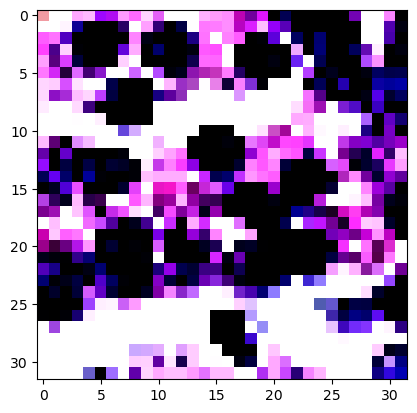

In [19]:
random_train_sample, random_train_label = train_ds[np.random.randint(0, len(train_ds))]
image2plot(random_train_sample)
print(f"label: {random_train_label}")

In [20]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)

# Building NN

Creating an util function to evaluate shapes after convolutions (yes, I'm so lazy)

In [22]:
def eval_shape(height, width, model, pool=0):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.MaxPool2d):
            kernel_size = layer.kernel_size
            stride = layer.stride
            padding = layer.padding
            dilation = layer.dilation
            if isinstance(layer, nn.Conv2d):
                height = np.floor((height + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
                width = np.floor((width + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
            elif isinstance(layer, nn.MaxPool2d):
                height = np.floor((height + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)
                width = np.floor((width + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)
    if pool:
        height /= pool
        width /= pool
    return int(height), int(width)

Our main neural model we will train.

In [23]:
class ConvWithReLU(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1):
        super(ConvWithReLU, self).__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                                   nn.ReLU())

    def forward(self, x):
        return self.block(x)


class CD2Conv(nn.Module):
    def __init__(self):
        super(CD2Conv, self).__init__()
        self.conv_block = nn.Sequential(
            ConvWithReLU(3, 32, 7),
            ConvWithReLU(32, 64, 5)
        )
        self.relu = nn.ReLU()
        h, w = eval_shape(32, 32, self.conv_block)
        self.size: int = h * w
        self.fc1 = nn.Linear(64 * self.size, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [24]:
dataloaders = {
    'train': train_dl,
    'validation': validation_dl
}

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CD2Conv().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criteria = nn.BCEWithLogitsLoss()

# NN training

In [26]:
stats = {
    'train': {
        'loss': [],
        'accuracy': []
    },
    'validation': {
        'loss': [],
        'accuracy': []
    }
}

In [35]:
def one_epoch(model,
              dataloader,
              criteria,
              optimizer=None,
              device=device):
    running_loss = 0.0
    running_accuracy = 0.0
    number_of_samples = 0
    for i, data in enumerate(tqdm(dataloader, desc='Batches')):
        x, y = data
        x = x.half().to(device)
        y = y.to(device).float()

        sample_size = x.size(0)

        if optimizer:
            optimizer.zero_grad()

        with autocast():
            output = model(x).view(len(x))
            print(f"output shape: {output.shape}\n"
                  f"y shape: {y.shape}")
            print(f"output: {output}")
            loss = criteria(output, y)
        output = torch.sigmoid(output)
        y = y.int()
        output = (output >= 0.5) * 1

        running_accuracy += torch.sum(output == y).item()
        running_loss += float(loss.item() * sample_size)
        number_of_samples += sample_size

        if optimizer:
            loss.backward()
            optimizer.step()

        if torch.cuda.is_available():
            del x, output, loss
            gc.collect()
            with torch.cuda.device(device):
                torch.cuda.empty_cache()

    loss = running_loss / len(dataloader.dataset)
    accuracy = running_accuracy / number_of_samples
    return loss, accuracy


def train(model,
          dataloaders,
          criteria,
          optimizer,
          epochs,
          stats,
          device):
    print("Epochs")
    for epoch in tqdm(range(epochs), desc="Epochs"):
        avg_train_loss, avg_train_accuracy = one_epoch(model, dataloaders['train'], criteria, optimizer)
        stats['train']['loss'].append(avg_train_loss)
        stats['train']['accuracy'].append(avg_train_accuracy)
        print(f"Training average loss - {avg_train_loss}, average accuracy - {avg_train_accuracy}")

        with torch.no_grad():
            avg_valid_loss, avg_valid_accuracy = one_epoch(model, dataloaders['validation'], criteria)
        stats['validation']['loss'].append(avg_valid_loss)
        stats['validation']['accuracy'].append(avg_valid_accuracy)
        print(f"Validation loss - {avg_valid_loss},  accuracy - {avg_valid_accuracy}")


In [ ]:
train(model, dataloaders, criteria, optimizer, device=device, stats=stats, epochs=50)

In [28]:
def fetch_json(path: str) -> dict:
    with open(path, "r") as file:
        json_file = json.load(file)
        file.close()
    return json_file


def save_json(json_dict: dict, path: str):
    with open(path, "w") as file:
        json.dump(json_dict, file)
        file.close()

In [29]:
result_dict = {model.__class__.__name__: stats}
save_json(result_dict, "stats.json")

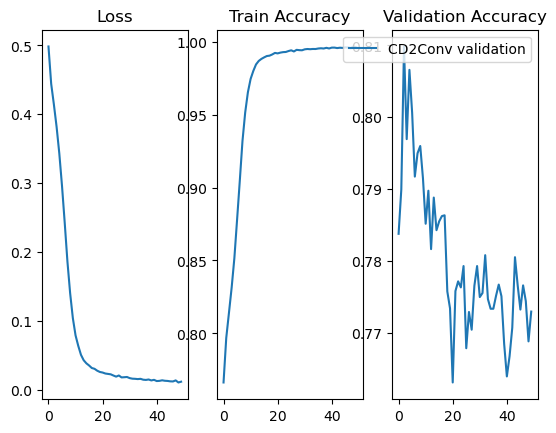

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
for k, v in result_dict.items():
    ax1.plot(v["train"]["loss"], label=f"{k} train")

    ax2.plot(v['train']['accuracy'], label=f'{k} train')
    ax3.plot(v['validation']['accuracy'], label=f'{k} validation')

ax1.set_title('Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Validation Accuracy')
plt.legend()
plt.show()


In [31]:
torch.save(
    {
        'epochs': 50,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    },
    os.path.join("weights", f'{model.__class__.__name__}.pt'))

We trained this model but as we can see, the model performs not so well on validation set.
Next thing we should do is to fix it. There are a few options - take the model and fully retrain it with new (augmented data) or try to train only on augmented data.
I choose the last.

# Improving NN
Loading trained model

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(os.path.join("weights", "CD2Conv.pt"))
model = CD2Conv().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criteria = nn.BCEWithLogitsLoss()

Define another data transformations for the dataset.

In [33]:
augmented_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.RandomRotation(degrees=45),
        transforms.CenterCrop(CENTER_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])

    ]
)

In [34]:
dataset = HistopathologicCancerDS(balanced_train_df, transform=augmented_transforms)

Converting images to tensors...


  0%|          | 0/178234 [00:00<?, ?it/s]

The dataset is ready for use.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0


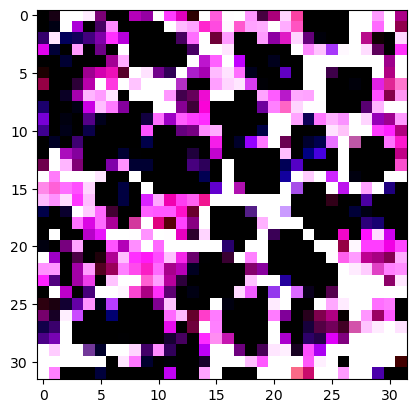

In [35]:
random_sample = dataset[np.random.randint(0, len(dataset))]
print(f"label: {random_sample[1]}")
image2plot(random_sample[0])

In [36]:
ds_len = len(dataset)
train_size = int(0.9 * ds_len)
validation_size = ds_len - train_size
train_ds, validation_ds = random_split(dataset, [train_size, validation_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)
dataloaders = {
    'train': train_dl,
    'validation': validation_dl
}

stats = {
    'train': {
        'loss': [],
        'accuracy': []
    },
    'validation': {
        'loss': [],
        'accuracy': []
    }
}

In [ ]:
train(model, dataloaders, criteria, optimizer, epochs=50, stats=stats, device=device)

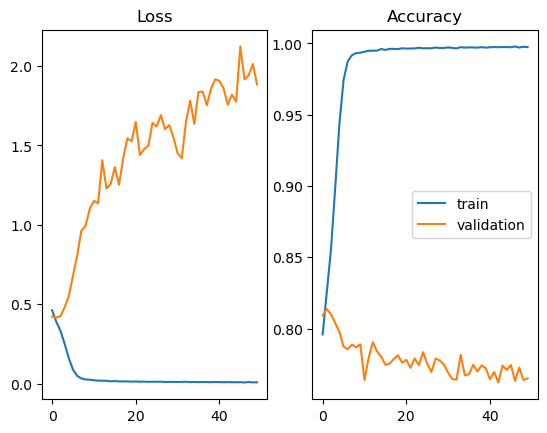

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(stats["train"]["loss"], label='train')
ax1.plot(stats['validation']['loss'], label='validation')
ax2.plot(stats['train']['accuracy'], label='train')
ax2.plot(stats['validation']['accuracy'], label='validation')

ax1.set_title('Loss')
ax2.set_title('Accuracy')
plt.legend()
plt.show()


In [42]:
torch.save(
    {
        'epochs': 50,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    },
    os.path.join("weights", f'{model.__class__.__name__}1.pt')
)

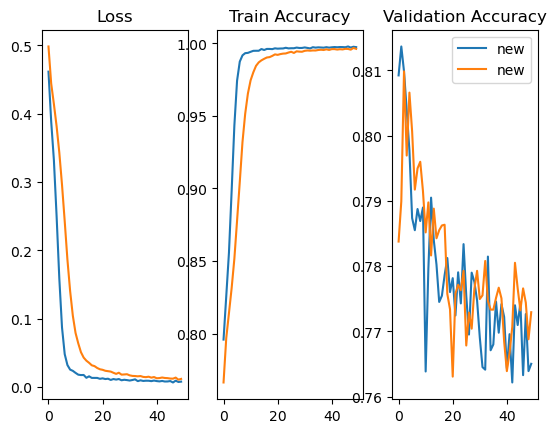

In [44]:
old_stats = fetch_json('stats.json')['CD2Conv']
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
ax1.plot(stats["train"]["loss"], label='new')
ax1.plot(old_stats['train']['loss'], label='old')
ax2.plot(stats['train']['accuracy'], label='new')
ax2.plot(old_stats['train']['accuracy'], label='old')
ax3.plot(stats['validation']['accuracy'], label='new')
ax3.plot(old_stats['validation']['accuracy'], label='new')

ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Validation Accuracy')
plt.legend()
plt.show()


In [75]:
checkpoint = torch.load(os.path.join("weights", "CD2Conv1.pt"))
model = CD2Conv().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

result size: (22, 22)


<All keys matched successfully>

In [78]:
for i, data in enumerate(tqdm(train_dl, desc='Batches')):
    x, y = data
    x = x.half().to(device)
    print(x.shape)
    y = y.to(device).float()

    sample_size = x.size(0)
    with torch.no_grad():
        with autocast():
            output = model(x).view(len(x))
        output = torch.sigmoid(output)
        output = (output >= 0.5) * 1
    break

Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

torch.Size([64, 3, 32, 32])
flatten: torch.Size([64, 30976])


In [ ]:
submission_list = []
for filename in tqdm(os.listdir('test')):
    with Image.open(os.path.join('test', filename)) as img:
        print(type(img))
        tensor = ds_transformer(img).half().to(device).reshape(1, 3, 32, 32)
        print(type(tensor))
        print(tensor.shape)
    with autocast():
        with torch.no_grad():
            output = model(tensor).reshape(-1)
        output = torch.sigmoid(output)
        label = (output >= 0.5) * 1
    submission_list.append([filename[:-4], label])

In [87]:
submission_list = [(i[0], int(i[1][0])) for i in submission_list]

In [100]:
submission_pd = pd.DataFrame(submission_list, columns=['id', 'label'])
submission_pd = submission_pd.set_index('id')

In [101]:
submission_pd.to_csv('submission.csv')